In [2]:
%matplotlib inline

# import libraries to read and plot statistical analyses of marine satellite data

import xarray as xr
import numpy as np
import os
import warnings
import cmocean as cmo
import matplotlib.pyplot as plt
import proplot as plot
from matplotlib import colors
from matplotlib import gridspec, ticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.geoaxes import GeoAxes
from mpl_toolkits.axes_grid1 import AxesGrid
from scipy.ndimage.filters import gaussian_filter
warnings.filterwarnings('ignore')
import seawater as sw
from dask.diagnostics import ProgressBar

In [3]:
land_resolution = '10m'
land_poly = cfeature.NaturalEarthFeature('physical', 'land', land_resolution,
                                        edgecolor='k',
                                        facecolor=cfeature.COLORS['land'])

In [37]:
#### SEA SURFACE TEMPERATURE DATASET ##### abs

file = xr.open_mfdataset('/home/bruno/git/CMEMS/sst_data/SST*',concat_dim='time')
sst_file = file.assign({'analysed_sst':file.analysed_sst-273})
sst_file.close()
#print(sst)

### Load a  CDM dataset - open time serie of cmems Colored Dissolved organic Matter L3 daily means ###

file = xr.open_mfdataset('/home/bruno/git/CMEMS/cdm_data/dataset*') #CDM data ## barra + barra invertida

d_file = file.reindex()

d_file.close()

### Load a  CHL dataset - open time serie of ESA/CCI Colored Dissolved organic Matter L3 daily means ###

#c_file = xr.open_mfdataset('/mnt/new_data/CMEMS/chla_data/dataset-oc-glo-opt-multi-l4-cdm443_4km_monthly-rep-v02-98_2019*') #CDM data ## barra + barra invertida

chl_file = xr.open_mfdataset('/home/bruno/git/CMEMS/chla_data/chl*')
chl_file = chl_file.reindex()

chl_file.close()

In [18]:
#d_file.attrs

In [17]:
#chl_file.var

In [16]:
#sst_file.attrs

In [38]:
sst_subset_file = sst_file.sel(lon=slice(-50.0, -40.0), lat=slice(-28.0, -21.0))#.where((bat>-200)&(bat<-10 ))
sst_subset_file.close()

d_subset_file = d_file.sel(lon=slice(-50.0, -40.0), lat=slice(-21.0, -28.0))#.where((bat>-200)&(bat<-10 ))
d_subset_file.close()

chl_subset_file = chl_file.sel(lon=slice(-50.0, -40.0), lat=slice(-21.0, -28.0))#.where((bat>-200)&(bat<-10 ))
chl_subset_file.close()


In [39]:
# LOAD BATHYMETRY AND INTERPOLATE DATA

dado = xr.open_dataset('/home/bruno/data/GEBCO_20-40S/gebco_2020_n-20.0_s-40.0_w-60.0_e-40.0.nc')

d_sub = d_subset_file.interp({'lon':sst_subset_file.lon,'lat':sst_subset_file.lat}).CDM

c_sub = chl_subset_file.CHL

bat = dado.interp({'lon':sst_subset_file.lon,'lat':sst_subset_file.lat}).elevation

d_sub.close()

c_sub.close()
bat.close()

In [40]:
sst_sub=sst_subset_file.analysed_sst
sst_sub.close()

In [41]:
### explorar

#d_sub.time ; sst_sub.time

calculando ano médio

In [15]:
with ProgressBar():
    d_mean = np.log10(d_sub).groupby('time.month').mean('time').mean(['lon','lat']).compute()    

[########################################] | 100% Completed |  2min 42.0s


In [26]:
with ProgressBar():
s_mean = sst_sub.groupby('time.month').mean('time').mean(['lon','lat']).compute()

In [10]:
with ProgressBar():
    c_mean = np.log10(c_sub).groupby('time.month').mean('time').mean(['longitude','latitude']).compute()

[########################################] | 100% Completed |  2.1s


correlação entre ano médio de cada váriavel

In [ ]:
xr.corr(d_sub, 
        c_sub, dim='time')#.plot()

In [17]:
xr.corr(d_mean, 
        s_mean, dim='month')#.plot()

<xarray.DataArray ()>
array(-0.88307536)

In [18]:
xr.corr(d_mean, 
        c_mean, dim='month')#.plot()

<xarray.DataArray ()>
array(0.98148985)

In [19]:
xr.corr(s_mean, 
        c_mean, dim='month')#.plot()

<xarray.DataArray ()>
array(-0.79490837)

PLOT (scatter plot)

EOF - oceanlab

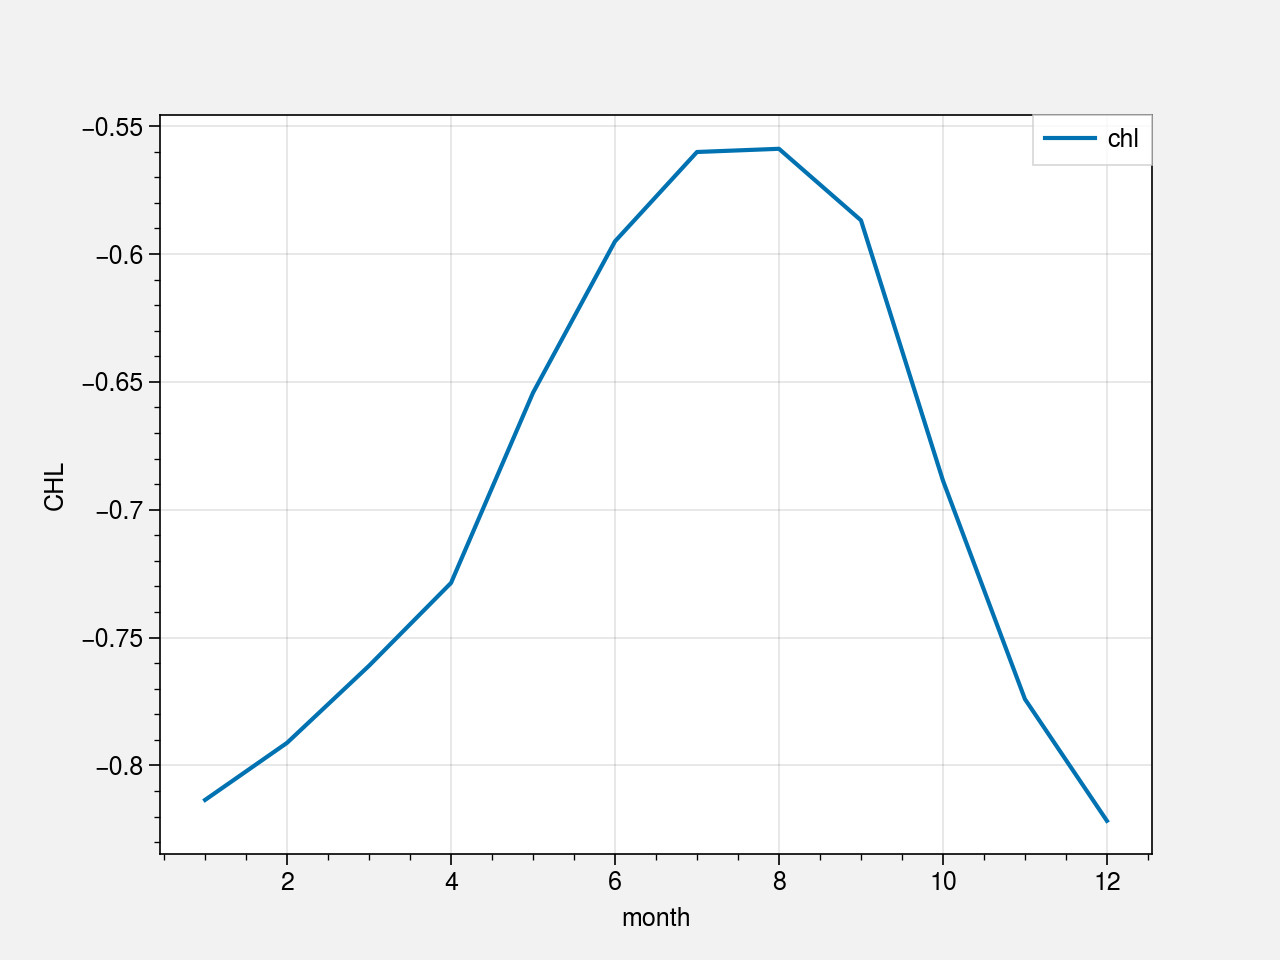

In [28]:
fig,ax = plt.subplots()

# d_mean.plot(x='month', color = 'red', label='CDM')
# ax.legend()

# # #plt.title('ano médio para área de estudo')
# plt.show

# s_mean.plot(x='month',label='sst')
# # plt.show()


c_mean.plot(x='month',label='chl')
ax.legend()
plt.show()


criar vetores ao longo das batimetrias

In [20]:
#------------------------- função montar uma matrix para um vetor de batimetria "suave"----------------------------------------------------

def extract_bat(lon,lat,topo,level,flevel):
    CT = plt.contour(gaussian_filter(lon,flevel),
                     gaussian_filter(lat,flevel),gaussian_filter(topo,flevel),
                     [level],colors='black',latlon=True,linewidths=0.7,linestyles='solid')
    # CT = plt.contour(lon,lat,topo,[-100],colors='black',latlon=True,linewidths=0.7,linestyles='solid')
    lli = []
    for i in range(len(CT.allsegs[0])):
        print(CT.allsegs[0][i].shape[0])
        lli.append(CT.allsegs[0][i].shape[0])
        
    lbat = CT.allsegs[0][np.argmax(lli)]
    print('Maior shape é'.format(CT.allsegs[0][np.argmax(lli)].shape))

    return lbat[:,0],lbat[:,1]


In [21]:
def hov_ext_cdm_dist(x,y,d_file):

    hov_cdm = []

    xi,yi = x.copy(),y.copy() 

    for i in range(len(xi)):
        print("{:03.1f}%".format(100*(i+1)/len(xi)),end="\r")
        hov_cdm.append(d_file.sel(lon=xi[i], lat=yi[i], method='nearest'))

    hov_cdm = xr.concat(hov_cdm,dim='distance')
    hov_cdm = hov_cdm.assign_coords({'distance':np.hstack([0,np.cumsum(sw.dist(yi,xi)[0])])}) #


    with ProgressBar():
        hov_cdm = hov_cdm.compute()
        
    hov_cdm = hov_cdm.interpolate_na('distance').interpolate_na('time')
    
    return hov_cdm

In [22]:
def hov_ext_chl_dist(x,y,chl_file):

    hov_chl = []

    xi,yi = x.copy(),y.copy() 

    for i in range(len(xi)):
        print("{:03.1f}%".format(100*(i+1)/len(xi)),end="\r")
        hov_chl.append(chl_file.sel(lon=xi[i], lat=yi[i], method='nearest'))

    hov_chl = xr.concat(hov_chl,dim='distance')
    hov_chl = hov_chl.assign_coords({'distance':np.hstack([0,np.cumsum(sw.dist(yi,xi)[0])])}) #


    with ProgressBar():
        hov_chl = hov_chl.compute()
        
    #hov_chl = hov_chl.interpolate_na('distance').interpolate_na('time')
    
    return hov_chl


In [23]:
def hov_ext_sst_dist(x,y,sst_file):

    hov_sst = []

    xi,yi = x.copy(),y.copy() 

    for i in range(len(xi)):
        print("{:03.1f}%".format(100*(i+1)/len(xi)),end="\r")
        hov_sst.append(sst_file.sel(lon=xi[i], lat=yi[i], method='nearest'))

    hov_sst = xr.concat(hov_sst,dim='distance')
    hov_sst = hov_sst.assign_coords({'distance':np.hstack([0,np.cumsum(sw.dist(yi,xi)[0])])}) #


    with ProgressBar():
        hov_sst = hov_sst.compute()
        
    hov_sst = hov_sst.interpolate_na('distance').interpolate_na('time')
    
    return hov_sst

In [24]:
# ## MATRIX FOR WIND ########
# def hov_ext_wind_dist(x,y,wind_d):

#     hov_wind = []
   
#     xi,yi = x.copy(),y.copy() 

#     for i in range(len(xi)):
#         print("{:03.1f}%".format(100*(i+1)/len(xi)),end="\r"),
#         hov_wind.append(wind_d.sel(lon=xi[i], lat=yi[i], method='nearest')),


#     hov_wind = xr.concat(hov_wind,dim='distance')
#     hov_wind = hov_wind.assign_coords({'distance':np.hstack([0,np.cumsum(sw.dist(yi,xi)[0])])})
  
#     with ProgressBar():
#         hov_wind = hov_wind.compute()
    
#     hov_wind = hov_wind.interpolate_na('distance').interpolate_na('time')
    
#     return hov_wind    
    

In [25]:
xbat,ybat,zbat = bat.lat.values,bat.lon.values,bat.values

284
Maior shape é
285
Maior shape é
284
Maior shape é
286
Maior shape é


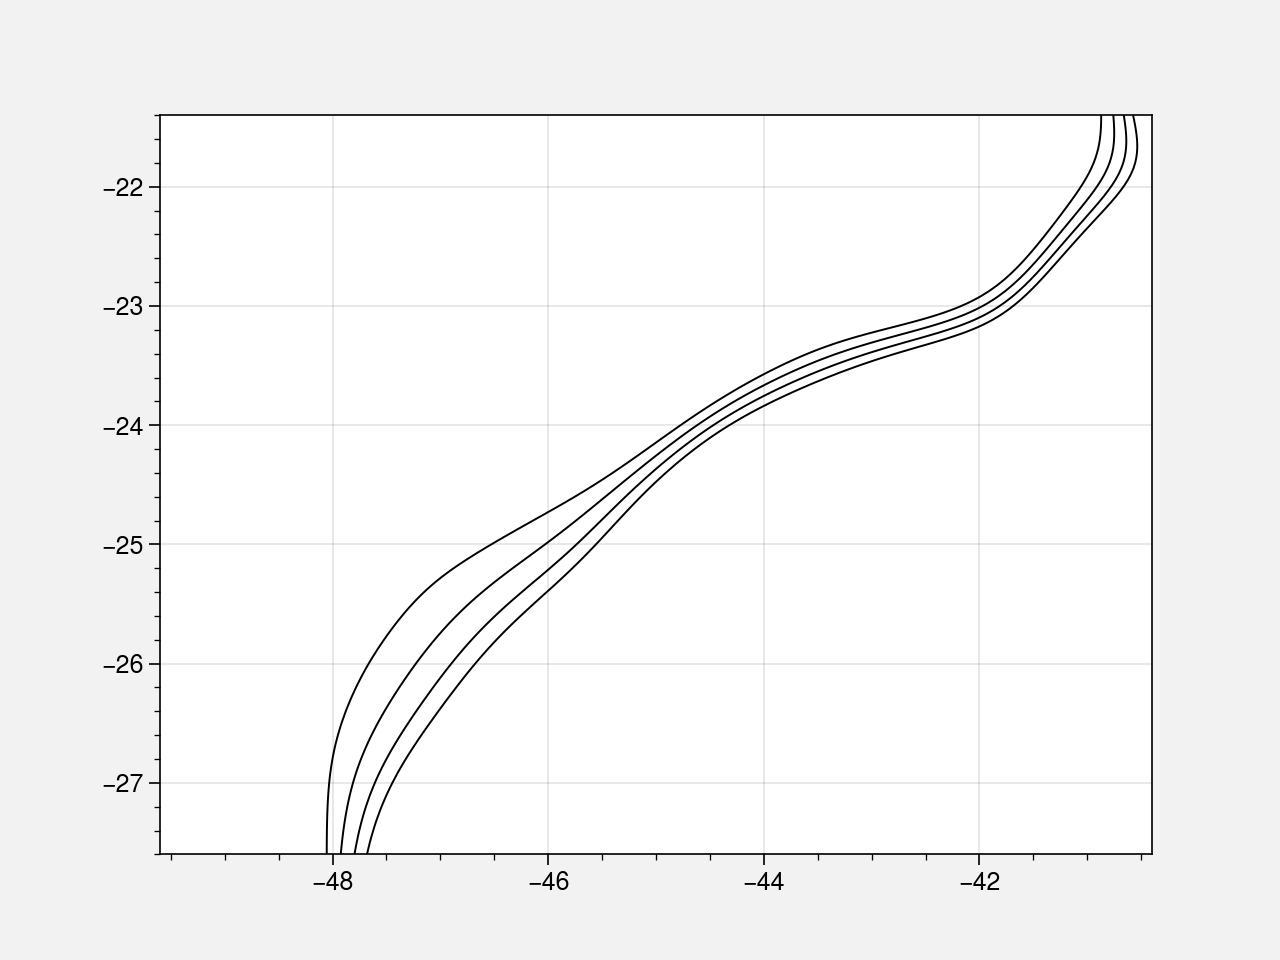

In [33]:
#----------- SELEÇÃO SEÇÕES DE ACORDO COM A BATIMETRIA SUAVE ---------------- #

x, y =  extract_bat(ybat, xbat, zbat, level = -50, flevel = 10) # SELECIONANDO VETORES
x_1, y_1 = extract_bat(ybat, xbat, zbat, level = -100, flevel = 10)
x_2, y_2 = extract_bat(ybat, xbat, zbat, level = -150, flevel = 10)
x_3, y_3 = extract_bat(ybat, xbat, zbat, level = -200, flevel = 10)


x,y = x[::10],y[::10]
x_1,y_1 = x_1[::10],y_1[::10] 
x_2,y_2 = x_2[::10],y_2[::10]
x_3,y_3 = x_3[::10],y_3[::10]


In [27]:
hov_cdm  = hov_ext_cdm_dist(x,y,d_file)
#hov_cdm_2 = hov_ext_cdm_dist(x_1,y_1,d_file)
#hov_cdm_3 = hov_ext_cdm_dist(x_2,y_2,d_file)
#hov_cdm_4 = hov_ext_cdm_dist(x_3,y_3,d_file)

[########################################] | 100% Completed |  5min 35.7s


In [ ]:
hov_chl  = hov_ext_chl_dist(x,y,chl_file)
#hov_chl_2 = hov_ext_chl_dist(x_1,y_1,chl_file)
#hov_chl_3 = hov_ext_chl_dist(x_2,y_2,chl_file)
#hov_chl_4 = hov_ext_chl_dist(x_3,y_3,chl_file)

[############                            ] | 30% Completed |  1min 16.5s

In [36]:
#hov_cdm.CDM
hov_chl

<xarray.Dataset>
Dimensions:    (distance: 29, time: 361)
Coordinates:
  * time       (time) object 1998-01-01 00:00:00 ... 1998-12-31 00:00:00
    lat        (distance) float32 -27.60417 -27.395838 ... -21.687504 -21.437504
    lon        (distance) float32 -48.062496 -48.062496 ... -40.89583 -40.854164
  * distance   (distance) float64 0.0 22.36 70.39 ... 1.046e+03 1.074e+03
Data variables:
    CHL        (distance, time) float32 0.45291692 0.29682744 ... 0.44830748
    CHL_error  (distance, time) float32 60.19 42.62 37.62 ... 74.04 74.54
Attributes:
    comment:                      average
    distribution_statement:       See CMEMS Data License
    site_name:                    GLO
    parameter_code:               CHL
    creation_time:                10:20:05 UTC
    creation_date:                2021-02-28 UTC
    nb_grid_bins:                 37324800
    easternmost_longitude:        180.0
    references:                   http://www.globcolour.info GlobColour has b...
    registration:                 5
    stop_date:                    2021-01-01 UTC
    lon_step:                     0.041666668
    cmems_product_id:             OCEANCOLOUR_GLO_CHL_L4_REP_OBSERVATIONS_009...
    naming_authority:             CMEMS
    northernmost_valid_latitude:  55.0
    grid_mapping:                 Equirectangular
    title:                        dataset-oc-glo-bio-multi-l4-chl_interpolate...
    period_end_day:               20201231
    duration_time:                PT155813S
    DPM_reference:                GC-UD-ACRI-PUG
    product_name:                 20201231_d-ACRI-L4-CHL-MULTI_4KM-GLO-REP
    netcdf_version_id:            4.3.3.1 of Jul  8 2016 18:15:50 $
    platform:                     Aqua,Suomi-NPP,Sentinel-3a,JPSS-1 (NOAA-20)...
    northernmost_latitude:        90.0
    IODD_reference:               GC-UD-ACRI-PUG
    stop_time:                    09:34:53 UTC
    file_quality_index:           0
    start_date:                   2020-12-30 UTC
    product_level:                4
    period_start_day:             20201231
    software_name:                globcolour_l3_reproject
    citation:                     The Licensees will ensure that original CME...
    software_version:             2020.1
    start_time:                   14:18:01 UTC
    easternmost_valid_longitude:  180.00002
    nb_bins:                      37324800
    southernmost_valid_latitude:  -78.62501
    nb_equ_bins:                  8640
    lat_step:                     0.041666668
    sensor_name_list:             MOD,VIR,OLA,VJ1,OLB
    institution:                  ACRI
    publication:                  Gohin, F., Druon, J. N., Lampert, L. (2002)...
    grid_resolution:              4.6383123
    sensor_name:                  MODISA,VIIRSN,OLCIa,VIIRSJ1,OLCIb
    product_type:                 day
    sensor:                       Moderate Resolution Imaging Spectroradiomet...
    Conventions:                  CF-1.4
    westernmost_valid_longitude:  -180.0
    contact:                      servicedesk.cmems@acri-st.fr
    westernmost_longitude:        -180.0
    source:                       surface observation
    earth_radius:                 6378.137
    southernmost_latitude:        -90.0
    pct_bins:                     100.0
    cmems_production_unit:        OC-ACRI-NICE-FR
    period_duration_day:          P1D
    history:                      
    nb_valid_bins:                19885298
    pct_valid_bins:               53.276368527091904
    parameter:                    Chlorophyll-a concentration
    History:                      Translated to CF-1.0 Conventions by Netcdf-...
    geospatial_lat_min:           -39.97917175292969
    geospatial_lat_max:           -19.979169845581055
    geospatial_lon_min:           -59.979164123535156
    geospatial_lon_max:           -40.02082824707031

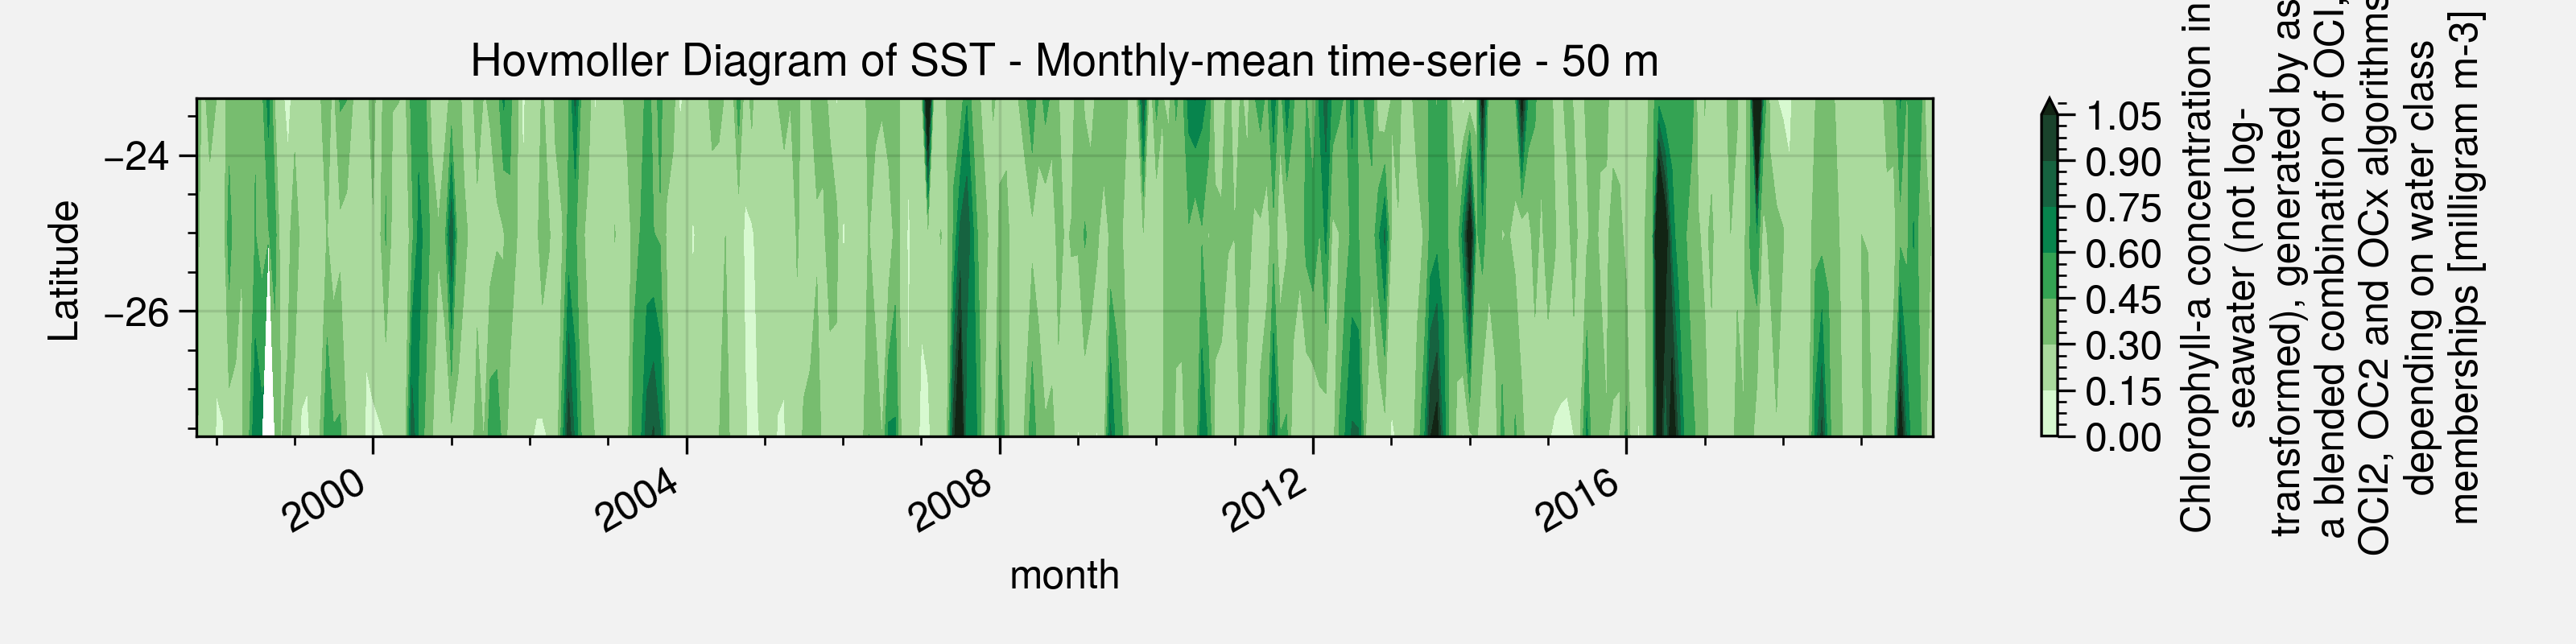

In [47]:
plt.figure(figsize=(8 ,2), dpi =200)
hov_chl_3.CHL.plot.contourf(y='latitude', cmap= cmo.cm.algae,robust=True)
plt.xlabel('month')
plt.ylabel('Latitude')
plt.title('Hovmoller Diagram of SST - Monthly-mean time-serie - 50 m')
plt.tight_layout()

In [48]:
"""
Função Sinfit Created on Sat May 23 10:07:55 2020

@author: paulo
"""

from numpy import sin, cos, matrix, pi, arctan2, arange
from numpy.linalg import lstsq, norm
from numpy.random import random


def sinfit(t, z, w):
    '''
    if t is time and z is the independent variable, w is the frequency to be
    used in fitting [A*sin(w*t + phi) + a*t + b] to z. w=2*pi/P
    returns (A, phi, a, b)
    '''
    B = matrix(z).T #
    rows = [[sin(w*t), cos(w*t), t, 1] for t in t]
    A = matrix(rows)
    (w, residuals, rank, sing_vals) = lstsq(A, B, rcond=None)
    phi = arctan2(w[1, 0], w[0, 0])
    A = norm([w[0, 0], w[1, 0]], 2)
    a = w[2, 0]
    b = w[3, 0]
    return (A, phi, a, b)

sinfunc = lambda A, phi, a, b, t: A*np.sin(w*t + phi) + a*t + b

In [93]:
w = 2*np.pi/365

amp = []
phi = []
trend = []
b = []
fit = []

for d in hov_chl_2.distance:
    z = hov_chl_2.CHL.sel(distance=d).values
    t = np.arange(len(z))
    
    notnan = ~np.isnan(z)
    P = sinfit(t[notnan], z[notnan], w)
    
    fiti = sinfunc(*P,t)
    
    amp.append(P[0])
    phi.append(P[1])
    trend.append(P[2])
    b.append(P[3])
    
    fit.append(fiti)
    
amp = np.array(amp)
phi = np.array(phi)
trend = np.array(trend)
b = np.array(b)
fit = np.array(fit)

In [95]:
# Adiciona as saídas da função para o Xarray.Dataset da respectiva matriz

hov_chl_2 = hov_chl_2.assign({
    'amp':(xr.ones_like(hov_chl_2.distance)*amp),
    'phi':(xr.ones_like(hov_chl_2.distance)*phi),
    'trend':(xr.ones_like(hov_chl_2.distance)*trend),
    'b':(xr.ones_like(hov_chl_2.distance)*b),
    'fit':(xr.ones_like(hov_chl_2.CHL)*fit),
})

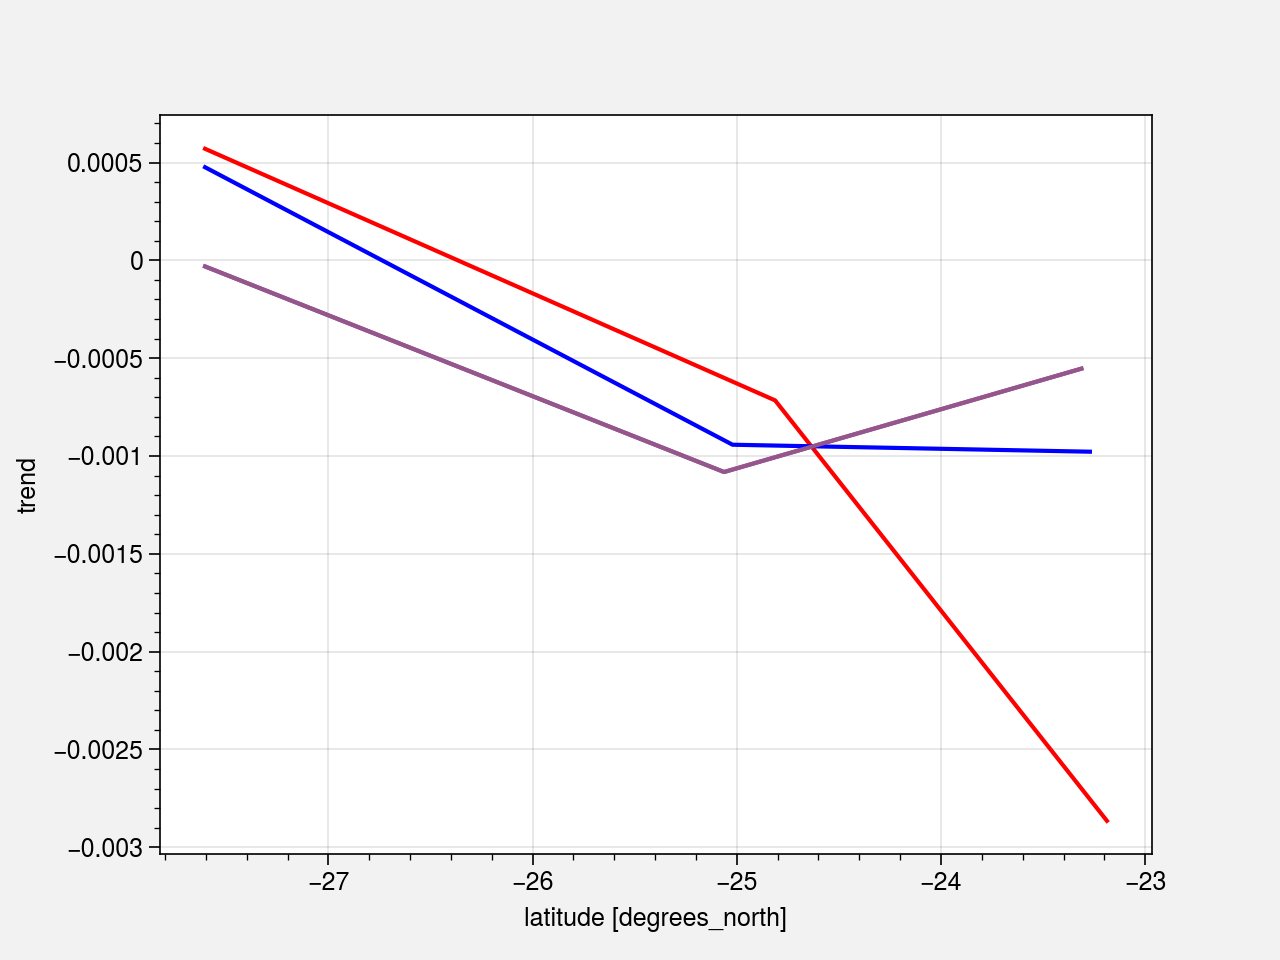

In [100]:
hov_chl.trend.plot.line(x= 'latitude', color='red')
hov_chl_2.trend.plot.line(x= 'latitude', color='purple')
hov_chl_3.trend.plot.line(x= 'latitude', color='blue')
hov_chl_4.trend.plot.line(x= 'latitude', color='purple')

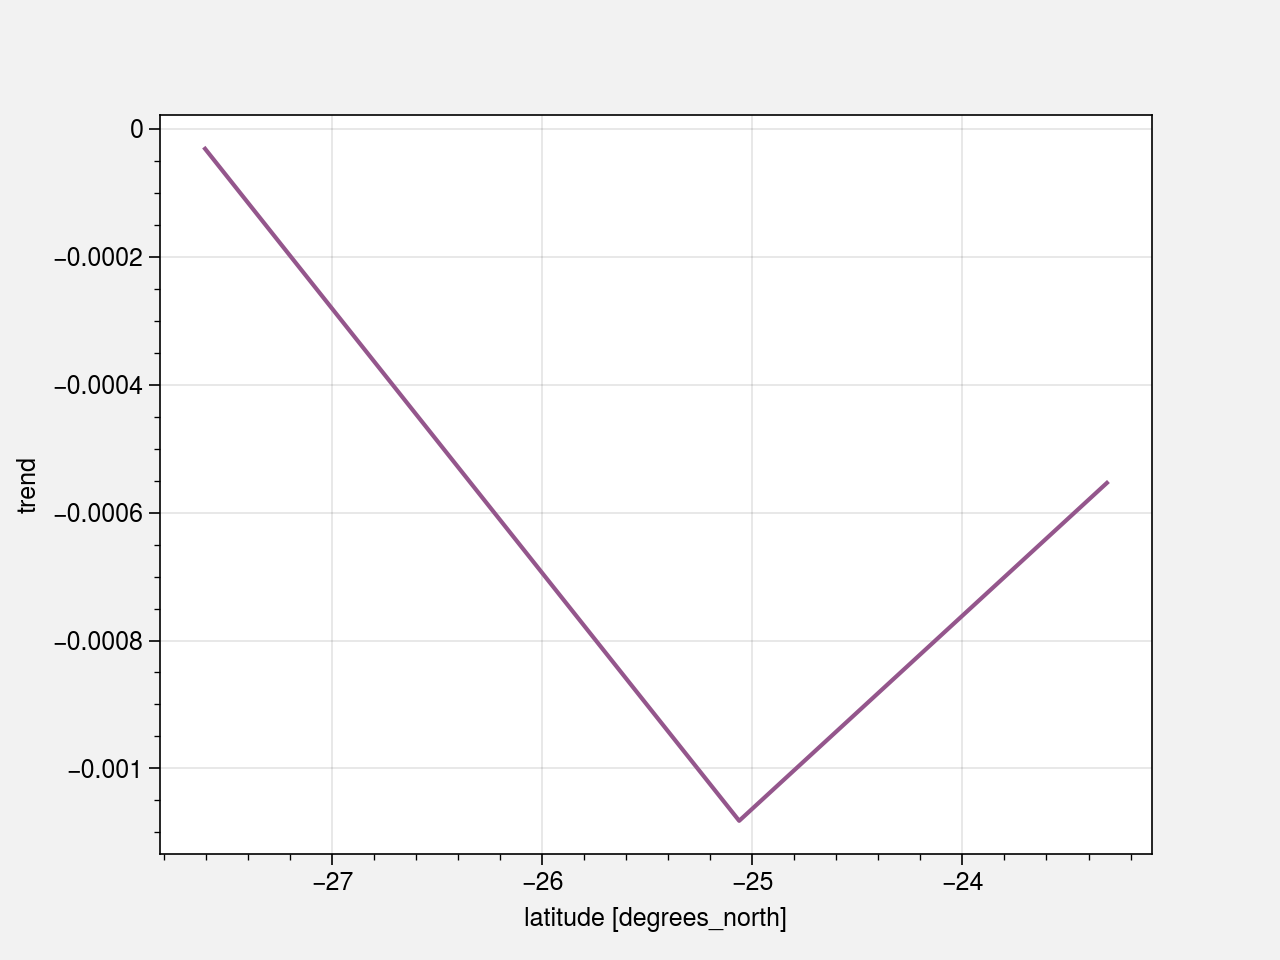

In [96]:
hov_chl_2.trend.plot.line(x= 'latitude', color='purple')

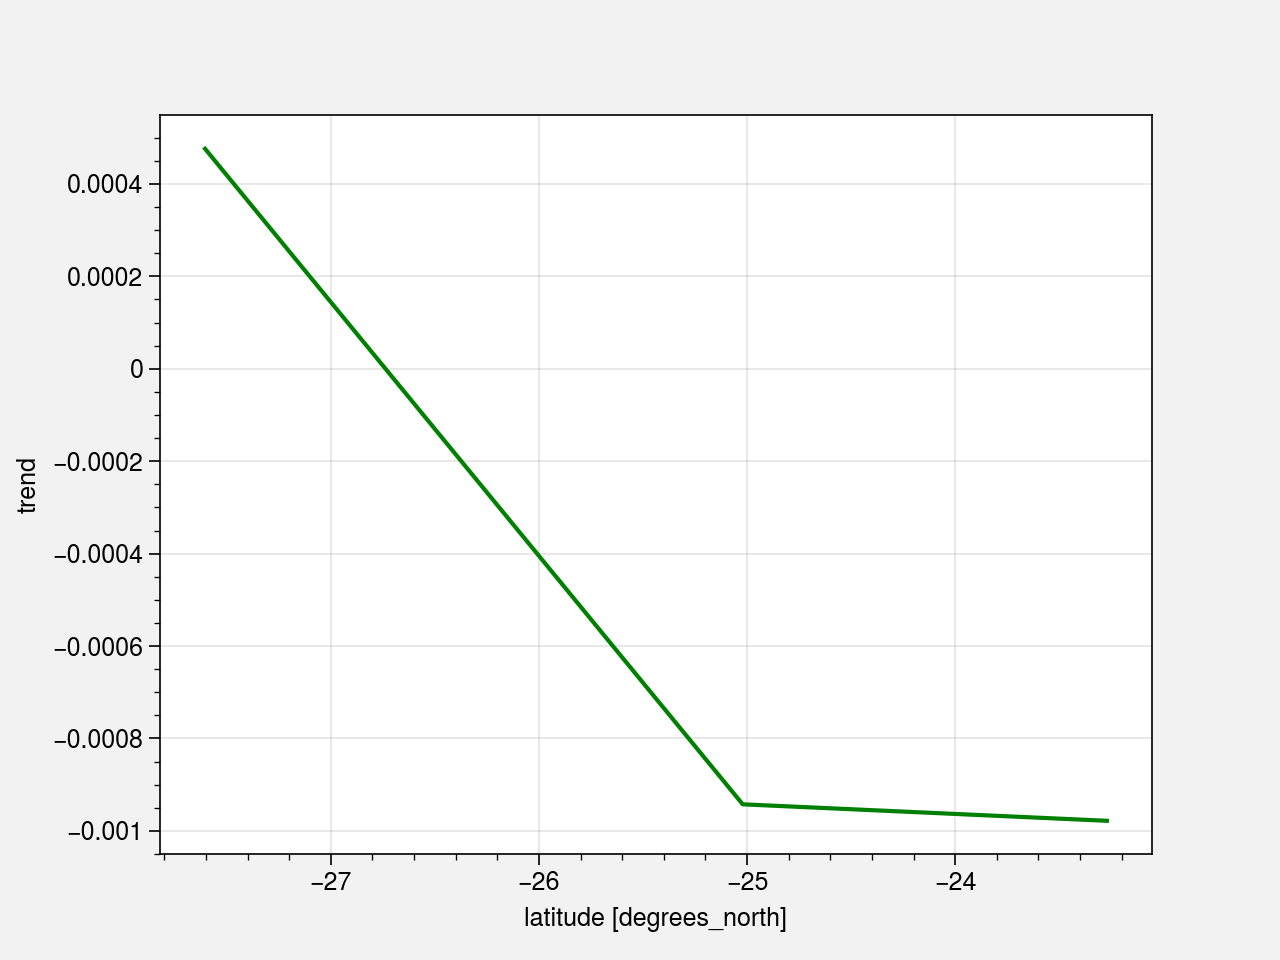

In [87]:
hov_chl_3.trend.plot.line(x= 'latitude', color='green')

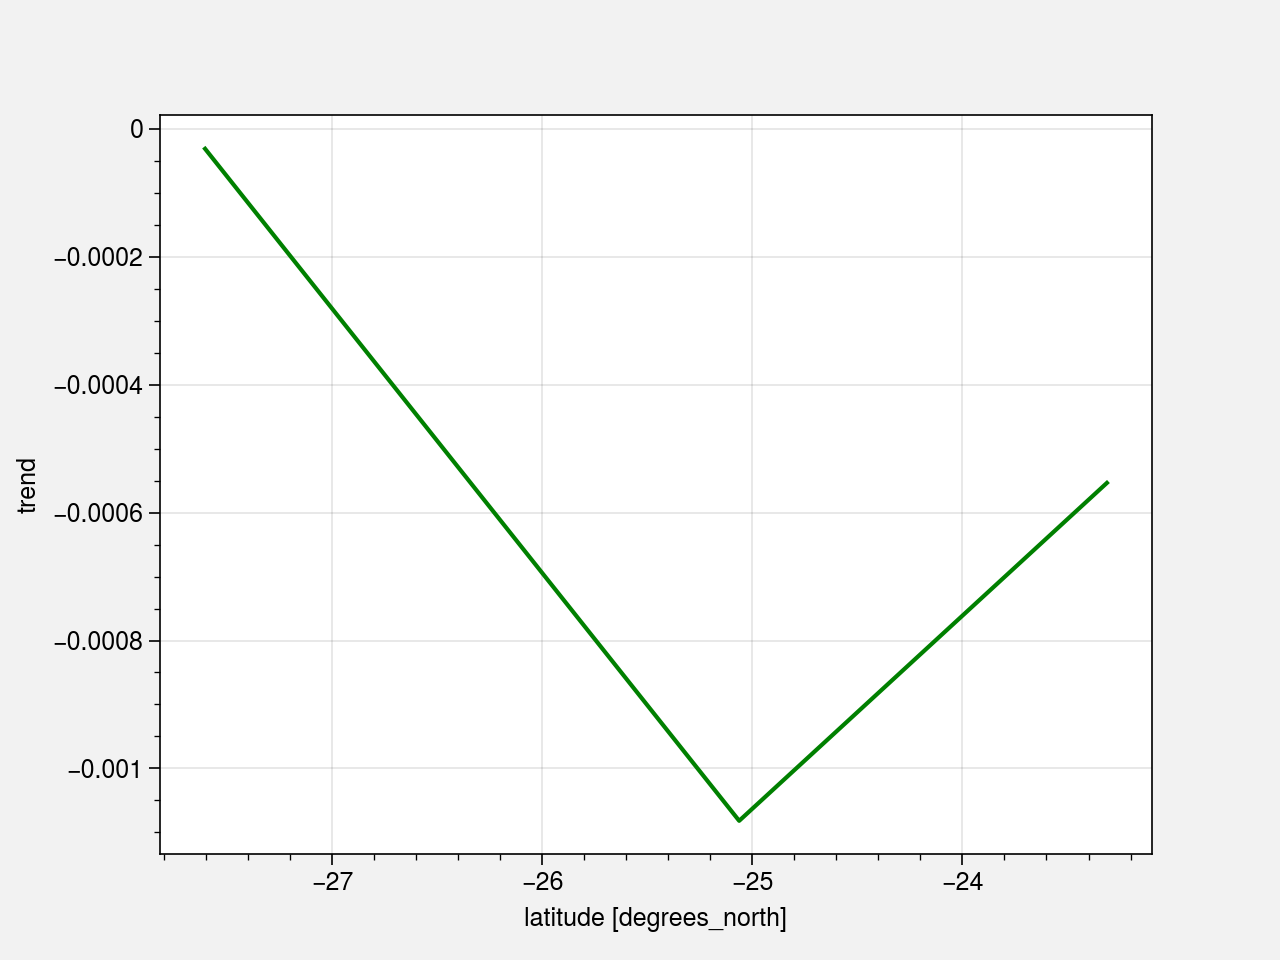

In [92]:
hov_chl_4.trend.plot.line(x= 'latitude', color='green')

In [ ]:
hov_sst  = hov_ext_sst_dist(x,y,sst_file)
hov_sst_2 = hov_ext_sst_dist(x_1,y_1,sst_file)
hov_sst_3 = hov_ext_sst_dist(x_2,y_2,sst_file)
hov_sst_4 = hov_ext_sst_dist(x_3,y_3,sst_file)